# 딥러닝 특강
## Deep Learning Practice 


#### Source from https://github.com/keai-kaist/CS492F-Spring

---

### 2-3. Overfitting and how to fight it

In the previous example, we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then start decreasing or being fixed.

In other words, our model would _overfit to the training data_. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing set (or data they haven't seen before). If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more training data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like _regularization_. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this part, we'll explore two common regularization techniques, weight regularization and dropout, and use them to improve our model.

First, we'll set up the environment as before.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print('Tensorflow: ', tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

Tensorflow:  2.3.0


#### Load the MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## Split train data into validation and train data
validation_images = train_images[:10000]
train_images = train_images[10000:]

validation_labels = train_labels[:10000]
train_labels = train_labels[10000:]

train_images = np.expand_dims(train_images, axis=-1) / 255
print(train_images.shape)

validation_images = np.expand_dims(validation_images, axis= -1)/ 255
print(validation_images.shape)

train_labels = np.int64(train_labels)
print(train_labels)

test_images = np.expand_dims(test_images, axis=-1) / 255
test_labels = np.int64(test_labels)
class_names = ['0','1','2','3','4','5','6','7','8','9']

11493376/11490434 [==============================] - 0s 0us/step
(50000, 28, 28, 1)
(10000, 28, 28, 1)
[3 8 7 ... 5 6 8]


#### Demonstrate overfitting by model size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model. In deep learning, the number of learnable parameters in a model is often referred to as the model's **"_capacity_"**. Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, **a mapping without any generalization power, but this would be useless when making predictions on previously unseen data**.

On the other hand, if the **network has limited memorization resources**, it will not be able to learn the mapping as easily. To minimize its loss, **it will have to learn compressed representations that have more predictive power.** At the same time, if you make your model too small, **it will have difficulty fitting to the training data.** There is a balance between "too much capacity" and "not enough capacity".

To find an appropriate model size empirically, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss. Let's try this on our movie review classification network.

We'll create a simple model using only Dense layers as a baseline, then create smaller and larger versions, and compare them.

#### Create a baseline model

In [7]:
# TODO: define a sequential model
baseline_model = tf.keras.Sequential([
    # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),

    # TODO: add the first dense layer with 512 nodes applying ReLU activation function
    tf.keras.layers.Dense(512, activation=tf.nn.relu),

    # TODO: add the first dense layer with 256 nodes applying ReLU activation function
    tf.keras.layers.Dense(256, activation=tf.nn.relu),

    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [8]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [9]:
baseline_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
BATCH_SIZE = 64
EPOCHS = 10

# Train the baseline model with partial training data and validation data we made 
baseline_history = baseline_model.fit(train_images, 
                            train_labels, 
                            epochs=EPOCHS,
                            validation_data=(validation_images, validation_labels),
                            batch_size=BATCH_SIZE)

Epoch 1/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2205 - accuracy: 0.9330 - val_loss: 0.1156 - val_accuracy: 0.9656
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0902 - accuracy: 0.9723 - val_loss: 0.1241 - val_accuracy: 0.9611
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0600 - accuracy: 0.9806 - val_loss: 0.1115 - val_accuracy: 0.9692
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0448 - accuracy: 0.9853 - val_loss: 0.0863 - val_accuracy: 0.9776
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0362 - accuracy: 0.9879 - val_loss: 0.0931 - val_accuracy: 0.9753
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0850 - val_accuracy: 0.9780
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.1004 - val_accuracy: 0.9730
Epoch 

#### Create a smaller model
Let's create a model with less hidden units to compare against the baseline model that we just created:

In [ ]:
smaller_model = tf.keras.Sequential([
    # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),

    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
smaller_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
smaller_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the smaller model with partial training data and validation data we made 
BATCH_SIZE = 64
EPOCHS = 10

# Train the baseline model with partial training data and validation data we made 
smaller_history = smaller_model.fit(train_images, 
                            train_labels, 
                            epochs=EPOCHS,
                            validation_data=(validation_images, validation_labels),
                            batch_size=BATCH_SIZE)

Epoch 1/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3253 - accuracy: 0.9095 - val_loss: 0.1906 - val_accuracy: 0.9477
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1490 - accuracy: 0.9572 - val_loss: 0.1370 - val_accuracy: 0.9604
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1048 - accuracy: 0.9692 - val_loss: 0.1126 - val_accuracy: 0.9673
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0787 - accuracy: 0.9771 - val_loss: 0.1012 - val_accuracy: 0.9705
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0626 - accuracy: 0.9810 - val_loss: 0.1008 - val_accuracy: 0.9697
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0503 - accuracy: 0.9845 - val_loss: 0.0917 - val_accuracy: 0.9734
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.0861 - val_accuracy: 0.9742
Epoch 

#### Create a bigger model
As an exercise, you can create an even larger model, and see how quickly it begins overfitting. Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [ ]:
bigger_model = tf.keras.Sequential([
    # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),

    # TODO: add the first dense layer with 1024 nodes applying ReLU activation function
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),

    # TODO: add the first dense layer with 512 nodes applying ReLU activation function
    tf.keras.layers.Dense(512, activation=tf.nn.relu),

    # TODO: add the first dense layer with 256 nodes applying ReLU activation function
    tf.keras.layers.Dense(256, activation=tf.nn.relu),

    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
bigger_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1290      
Total params: 1,494,154
Trainable params: 1,494,154
Non-trainable params: 0
____________________________________________

In [ ]:

bigger_model.compile(
              optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the bigger model with partial training data and validation data we made 
bigger_history = bigger_model.fit(train_images, 
                            train_labels, 
                            epochs=EPOCHS,
                            validation_data=(validation_images, validation_labels),
                            batch_size=BATCH_SIZE)

Epoch 1/10
782/782 [==============================] - 15s 20ms/step - loss: 0.2195 - accuracy: 0.9321 - val_loss: 0.1428 - val_accuracy: 0.9571
Epoch 2/10
782/782 [==============================] - 15s 20ms/step - loss: 0.0968 - accuracy: 0.9702 - val_loss: 0.1304 - val_accuracy: 0.9577
Epoch 3/10
782/782 [==============================] - 15s 20ms/step - loss: 0.0674 - accuracy: 0.9790 - val_loss: 0.1112 - val_accuracy: 0.9673
Epoch 4/10
782/782 [==============================] - 15s 20ms/step - loss: 0.0523 - accuracy: 0.9840 - val_loss: 0.0846 - val_accuracy: 0.9738
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0427 - accuracy: 0.9865 - val_loss: 0.0837 - val_accuracy: 0.9783
Epoch 6/10
782/782 [==============================] - 15s 20ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.1014 - val_accuracy: 0.9762
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0317 - accuracy: 0.9906 - val_loss: 0.0906 - val_accuracy:

#### Plot the training and validation loss
The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model). Here, the smaller network begins overfitting later than the baseline model (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting.

In [ ]:
history_dict = baseline_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')
        
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    
    plt.xlim([0,max(history.epoch)])

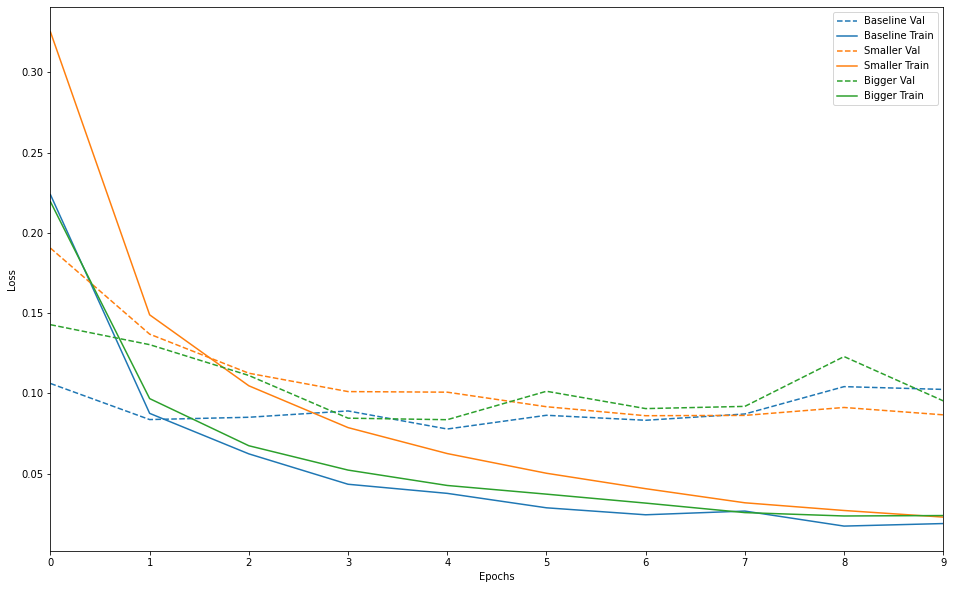

In [ ]:
plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

Notice that the larger network begins overfitting almost right away, after just one epoch, and overfits much more severely. **The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss)**, but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

#### Solution 1: Add weight regularization

Given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones. A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). 

Thus a common way to mitigate overfitting is to **put constraints on the complexity of a network by forcing its weights only to take small values**, which **makes the distribution of weight values more "regular".** This is called **"_weight regularization_"**, and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

 - [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

 - [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.
 
In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [ ]:
l2_model = tf.keras.Sequential([
        # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),

    # TODO: add the first dense layer with 512 nodes applying ReLU activation function
    #                   with L2 regularization term  (tf.keras.regularizers.l2)
    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.001),  activation=tf.nn.relu),

    # TODO: add the first dense layer with 256 nodes applying ReLU activation function
    #                   with L2 regularization term  (tf.keras.regularizers.l2)
    tf.keras.layers.Dense(256,kernel_regularizer=tf.keras.regularizers.l2(0.001),  activation=tf.nn.relu),

    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    #                   with L2 regularization term  (tf.keras.regularizers.l2)
    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
l2_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_42 (Dense)             (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Configure the model with 
#                optimize: Adam optimizer
#                loss func: Binary crossentropy
#                metrics: Accuracy
l2_model.compile(
         optimizer='adam', 
         loss='sparse_categorical_crossentropy',
         metrics=['accuracy'])

l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2 to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time.

Here's the impact of our L2 regularization penalty:

In [ ]:
# Train the l2 model with partial training data and validation data we made 
l2_model_history = l2_model.fit(train_images, 
                            train_labels, 
                            epochs=EPOCHS,
                            validation_data=(validation_images, validation_labels),
                            batch_size=BATCH_SIZE)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6928 - accuracy: 0.9250 - val_loss: 0.4152 - val_accuracy: 0.9562
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3438 - accuracy: 0.9599 - val_loss: 0.2948 - val_accuracy: 0.9638
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2696 - accuracy: 0.9658 - val_loss: 0.2693 - val_accuracy: 0.9628
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2369 - accuracy: 0.9688 - val_loss: 0.2350 - val_accuracy: 0.9689
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2128 - accuracy: 0.9722 - val_loss: 0.2420 - val_accuracy: 0.9618
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1976 - accuracy: 0.9740 - val_loss: 0.2319 - val_accuracy: 0.9638
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1911 - accuracy: 0.9751 - val_loss: 0.2067 - val_accuracy: 0.9691
Epoch 

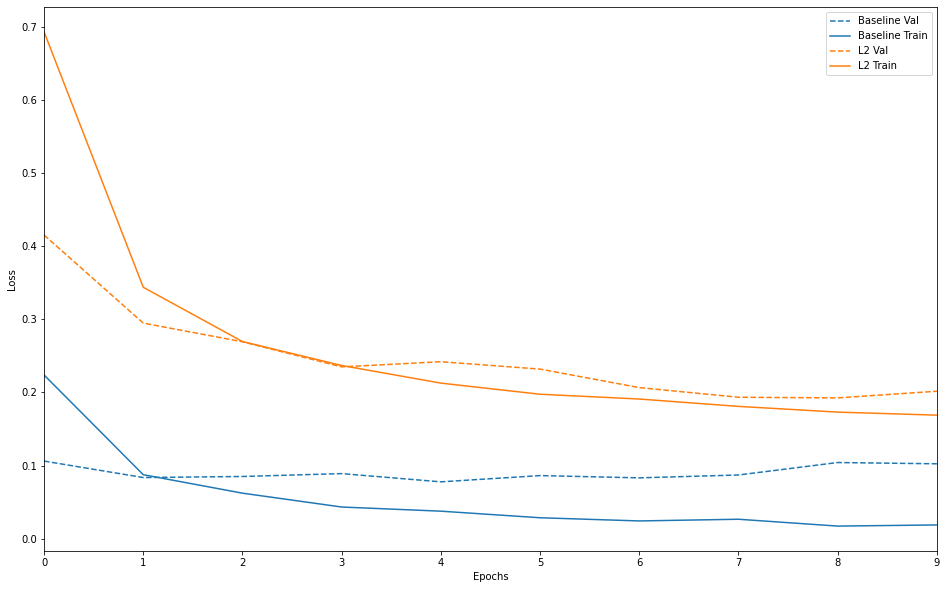

In [ ]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

As you can see, the L2 regularized model has become much more resistant to overfitting than the baseline model, even though both models have the same number of parameters.

#### Solution 2: Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. 

<img src="https://github.com/DaeHyeonNam/deep-learning-lecture/blob/master/images/dropout.png?raw=1"  width="500">

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our MNIST network to see how well they do at reducing overfitting:

In [11]:
dp_model = tf.keras.Sequential([
        # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),

    # TODO: add a dropout layer with 0.2 dropout rate
    tf.keras.layers.Dropout(0.2),

    # TODO: add the first dense layer with 512 nodes applying ReLU activation function
    tf.keras.layers.Dense(512, activation=tf.nn.relu),

    # TODO: add a dropout layer with 0.2 dropout rate
    tf.keras.layers.Dropout(0.2),

    # TODO: add the first dense layer with 256 nodes applying ReLU activation function
    tf.keras.layers.Dense(256, activation=tf.nn.relu),

    # TODO: add a dropout layer with 0.2 dropout rate
    tf.keras.layers.Dropout(0.2),

    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    # TODO: add a dropout layer with 0.2 dropout rate
    tf.keras.layers.Dropout(0.2),

    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [12]:
dp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [13]:
# Configure the model with 
#                optimize: Adam optimizer
#                loss func: Binary crossentropy
#                metrics: Accuracy
dp_model.compile(
optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']

)

In [14]:
# Train the dropout model with partial training data and validation data we made 

dp_model_history = dp_model.fit(train_images, 
                            train_labels, 
                            epochs=EPOCHS,
                            validation_data=(validation_images, validation_labels),
                            batch_size=BATCH_SIZE)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3446 - accuracy: 0.8941 - val_loss: 0.1476 - val_accuracy: 0.9559
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.1620 - accuracy: 0.9504 - val_loss: 0.0993 - val_accuracy: 0.9698
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1259 - accuracy: 0.9617 - val_loss: 0.0775 - val_accuracy: 0.9772
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1089 - accuracy: 0.9669 - val_loss: 0.0799 - val_accuracy: 0.9761
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0912 - accuracy: 0.9720 - val_loss: 0.0766 - val_accuracy: 0.9779
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0863 - accuracy: 0.9728 - val_loss: 0.0782 - val_accuracy: 0.9770
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0762 - accuracy: 0.9762 - val_loss: 0.0706 - val_accuracy: 0.9789
Epoch 

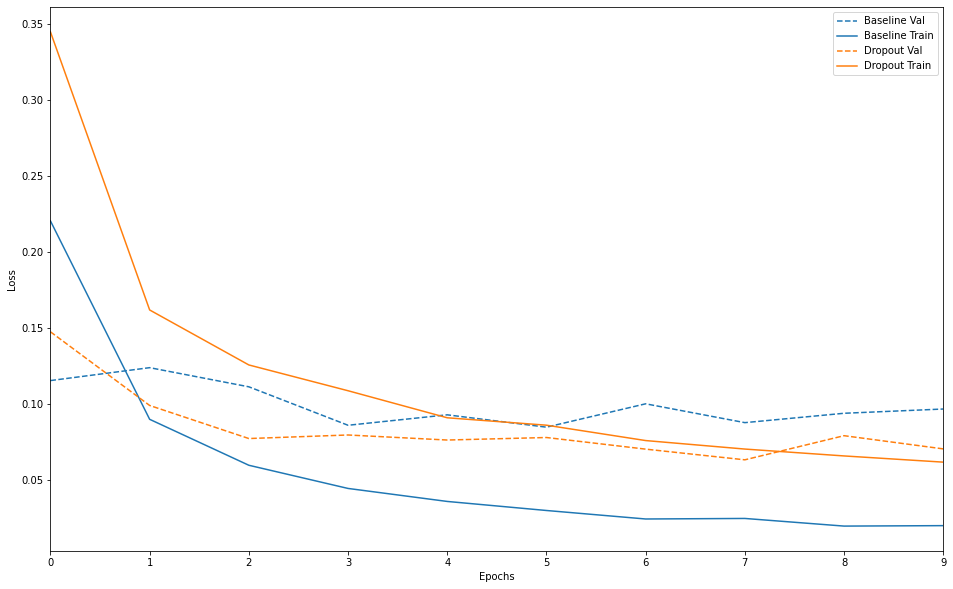

In [17]:
plot_history([('baseline', baseline_history),
              ('dropout', dp_model_history)])

Adding dropout is a clear improvement over the baseline model.

To recap: here the most common ways to prevent overfitting in neural networks:

- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.

And two important approaches not covered in this guide are data-augmentation and batch normalization.